In [18]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
import poppy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3
import adefc_vortex.scoob_model as scoobm

wavelength = 633e-9

In [2]:
date = 20241028
fit_ref = utils.load_pickle(f'data/{date}_fdpr2_fit_ref.pkl')
fit_F = utils.load_pickle(f'data/{date}_fdpr2_fit_F.pkl')
fit_cross = utils.load_pickle(f'data/{date}_fdpr2_fit_cross.pkl')
fit_reg = utils.load_pickle(f'data/{date}_fdpr2_fit_reg.pkl')
fit_ring_16 = utils.load_pickle(f'data/{date}_fdpr2_fit_ring_16.pkl')
fit_ring_15 = utils.load_pickle(f'data/{date}_fdpr2_fit_ring_15.pkl')
fit_ring_14 = utils.load_pickle(f'data/{date}_fdpr2_fit_ring_14.pkl')
fit_ring_13 = utils.load_pickle(f'data/{date}_fdpr2_fit_ring_13.pkl')

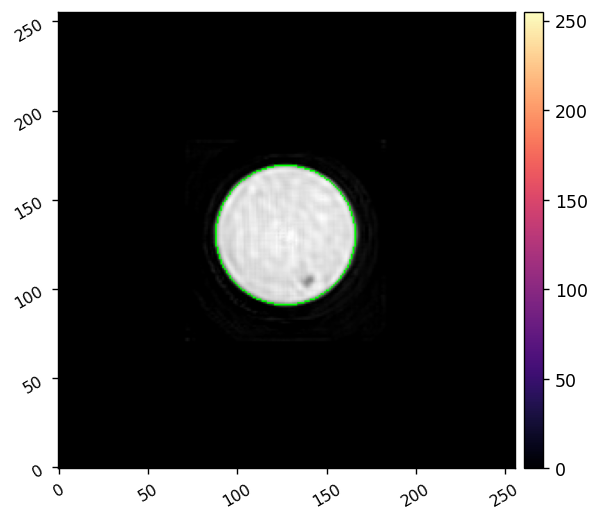

In [12]:
# Load picture and detect edges
image = img_as_ubyte(fit_ref['amp_est']/np.max(fit_ref['amp_est']))
edges = canny(image, sigma=1, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(30, 45, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

# Draw them
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (0, 255, 0)
imshow1(image, figsize=(5,5))

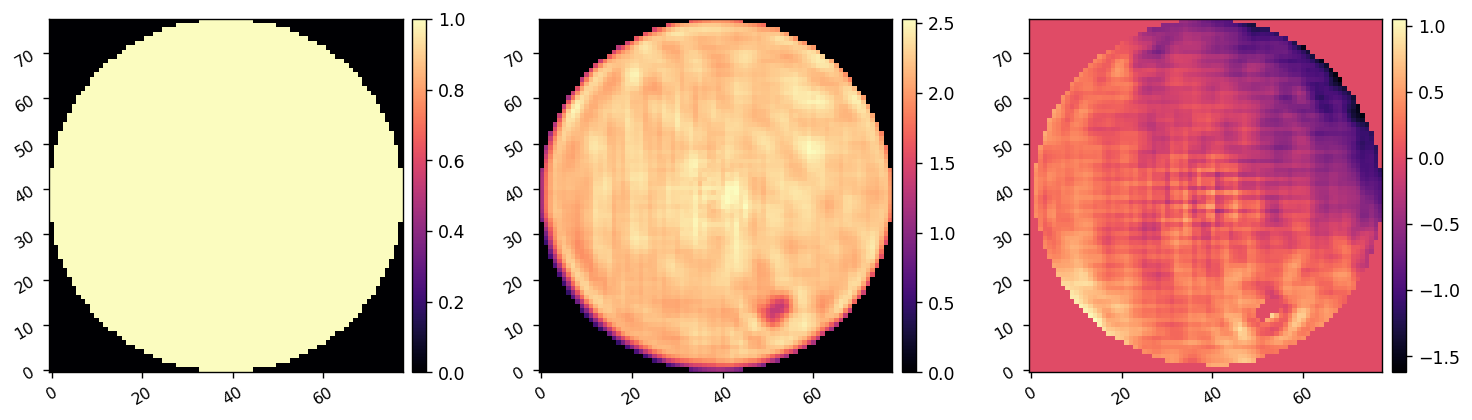

In [13]:
amp_est_ref = fit_ref['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_ref = fit_ref['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
Nfit = amp_est_ref.shape[0]
y,x = (np.indices((Nfit, Nfit)) - Nfit/2+1/2)
r = np.sqrt(x**2 + y**2)
fit_mask = r<(radii[0])

amp_est_ref *= fit_mask
phs_est_ref *= fit_mask
imshow3(fit_mask, amp_est_ref, phs_est_ref)

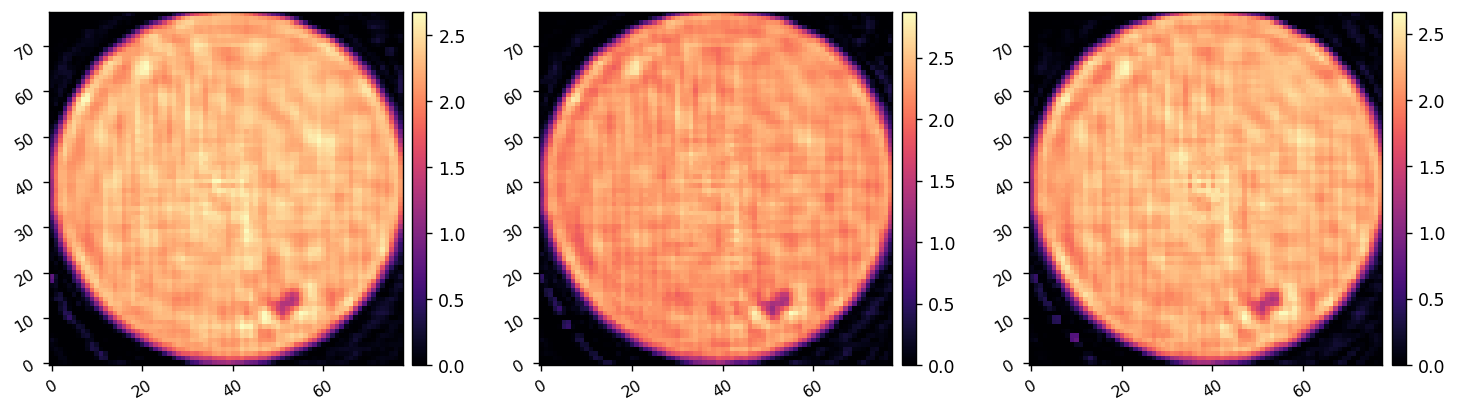

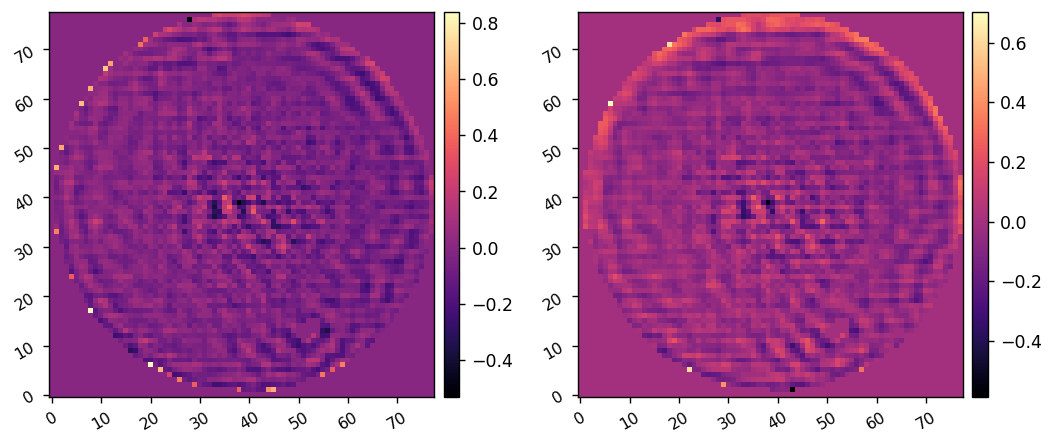

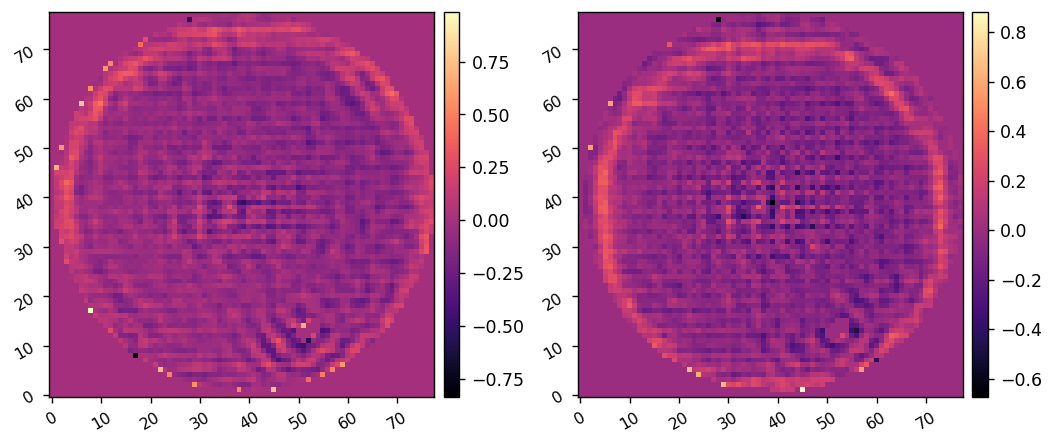

In [14]:
amp_est_ring_16 = fit_ring_16['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_ring_16 = fit_ring_16['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
amp_est_ring_16 *= fit_mask
phs_est_ring_16 *= fit_mask

amp_est_ring_15 = fit_ring_15['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_ring_15 = fit_ring_15['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
# amp_est_ring_15 *= fit_mask
phs_est_ring_15 *= fit_mask

amp_est_ring_14 = fit_ring_14['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_ring_14 = fit_ring_14['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
# amp_est_ring_14 *= fit_mask
phs_est_ring_14 *= fit_mask

amp_est_ring_13 = fit_ring_13['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_ring_13 = fit_ring_13['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
# amp_est_ring_13 *= fit_mask
phs_est_ring_13 *= fit_mask

del_phs_ring_16 = phs_est_ring_16 - phs_est_ref
del_phs_ring_15 = phs_est_ring_15 - phs_est_ref
del_phs_ring_14 = phs_est_ring_14 - phs_est_ref
del_phs_ring_13 = phs_est_ring_13 - phs_est_ref
imshow3(amp_est_ring_15, amp_est_ring_14, amp_est_ring_13)

imshow2(del_phs_ring_16, del_phs_ring_15)
imshow2(del_phs_ring_14, del_phs_ring_13)

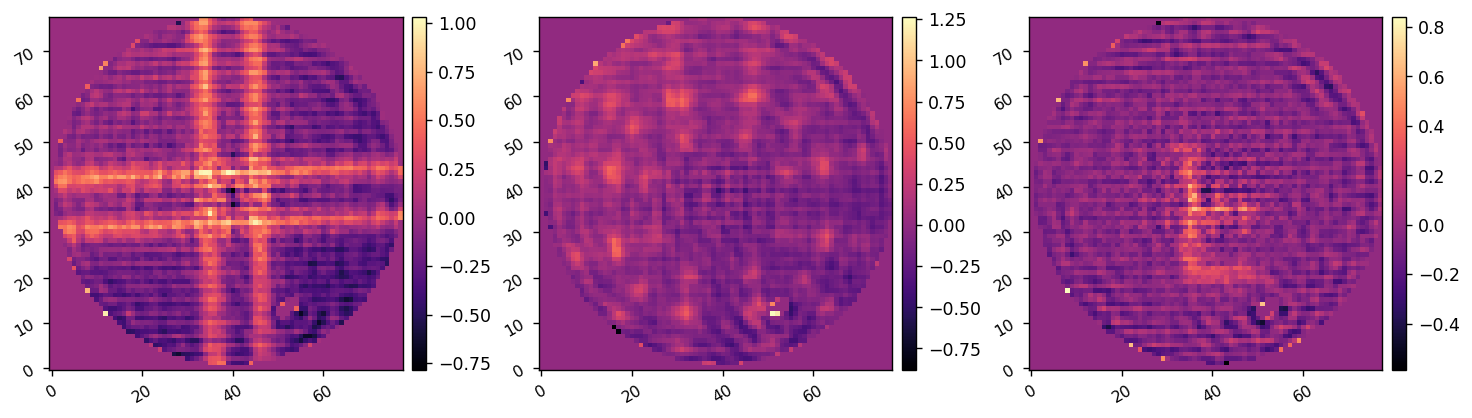

In [16]:
phs_est_cross = fit_cross['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_cross *= fit_mask
del_phs_cross =  xp.array(phs_est_cross - phs_est_ref)

phs_est_reg = fit_reg['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_reg *= fit_mask
del_phs_reg = xp.array(phs_est_reg - phs_est_ref)

phs_est_F = fit_F['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_F *= fit_mask
del_phs_F = xp.array(phs_est_F - phs_est_ref)

imshow3(del_phs_cross, del_phs_reg, del_phs_F)

# Fit to the cross, ring, and reg commands to the model.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


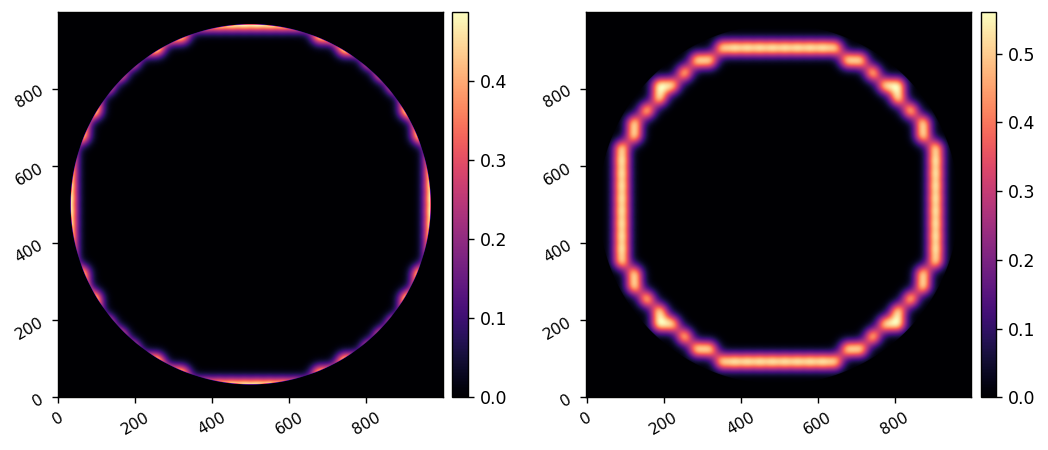

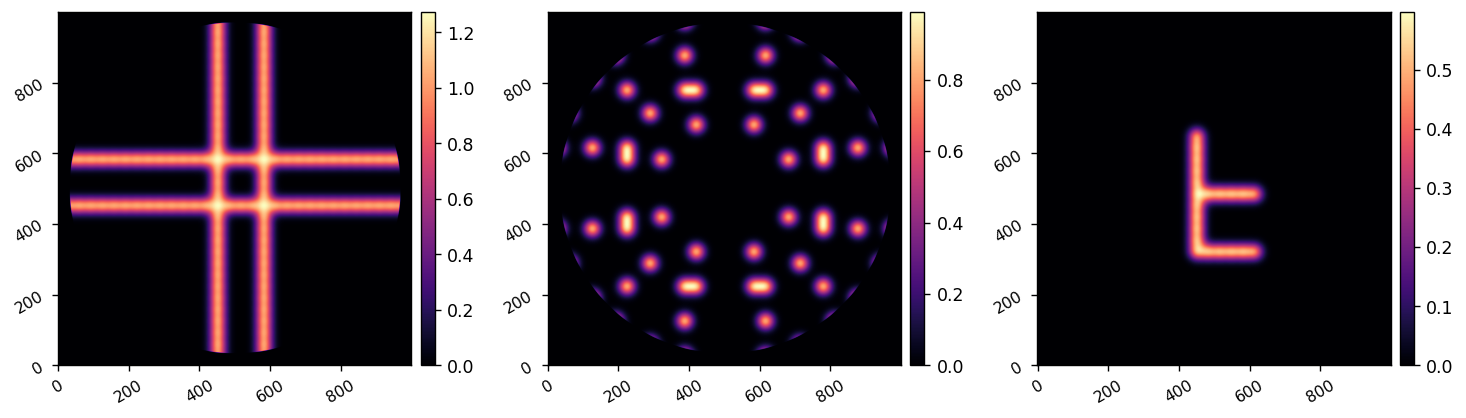

In [9]:
reload(rmad)
M = rmad.MODEL()
# M.flip_lyot_ud = 1
# M.xp_rotation = -2

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 178

fpwf, Epup, dm_phasor, Elp, Els = M.forward(fit_ring_15['command'][M.dm_mask], use_vortex=False, return_ints=True)
# m_dm_phs_ring_15 = xp.angle(utils.pad_or_crop(Elp, M.npix)) * M.APERTURE
m_dm_phs_ring_15 = xp.angle(utils.pad_or_crop(Els, M.npix)) * M.LYOT

fpwf, Epup, dm_phasor, Elp, Els = M.forward(fit_ring_13['command'][M.dm_mask], use_vortex=False, return_ints=True)
# m_dm_phs_ring_13 = xp.angle(utils.pad_or_crop(Elp, M.npix)) * M.APERTURE
m_dm_phs_ring_13 = xp.angle(utils.pad_or_crop(Els, M.npix)) * M.LYOT

fpwf, Epup, dm_phasor, Elp, Els = M.forward(fit_cross['command'][M.dm_mask], use_vortex=False, return_ints=True)
# m_dm_phs_cross = xp.angle(utils.pad_or_crop(Elp, M.npix)) * M.APERTURE
m_dm_phs_cross = xp.angle(utils.pad_or_crop(Els, M.npix)) * M.LYOT

fpwf, Epup, dm_phasor, Elp, Els = M.forward(fit_reg['command'][M.dm_mask], use_vortex=False, return_ints=True)
# m_dm_phs_reg = xp.angle(utils.pad_or_crop(Elp, M.npix))* M.APERTURE
m_dm_phs_reg = xp.angle(utils.pad_or_crop(Els, M.npix)) * M.LYOT

fpwf, Epup, dm_phasor, Elp, Els = M.forward(fit_F['command'][M.dm_mask], use_vortex=False, return_ints=True)
# m_dm_phs_F = xp.angle(utils.pad_or_crop(Elp, M.npix))* M.APERTURE
m_dm_phs_F = xp.angle(utils.pad_or_crop(Els, M.npix)) * M.LYOT


imshow2(m_dm_phs_ring_15, m_dm_phs_ring_13)
imshow3(m_dm_phs_cross, m_dm_phs_reg, m_dm_phs_F)

In [21]:
M.lyot_ratio * M.npix

np.float64(934.7826086956522)

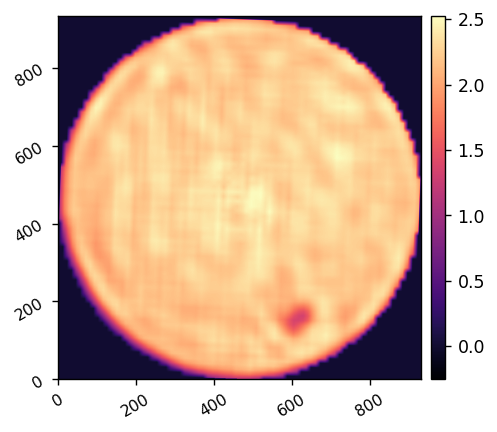

(934, 934)


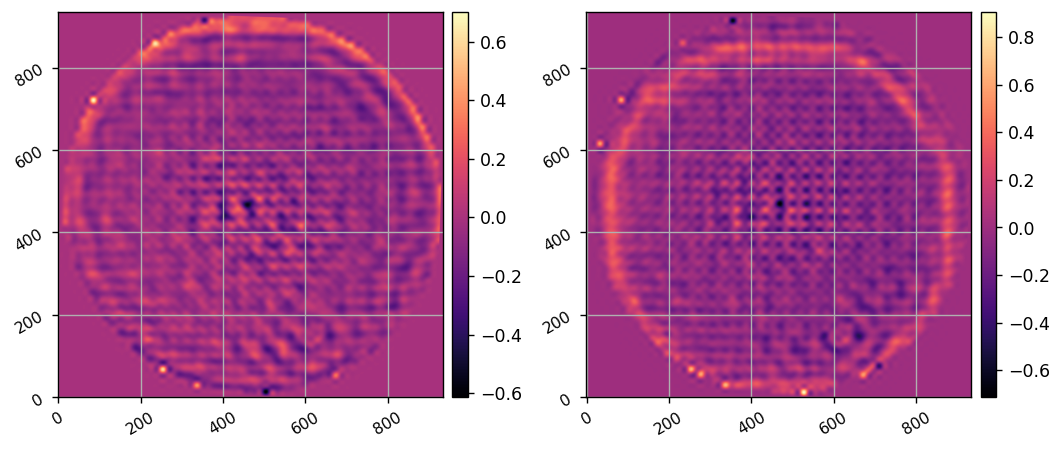

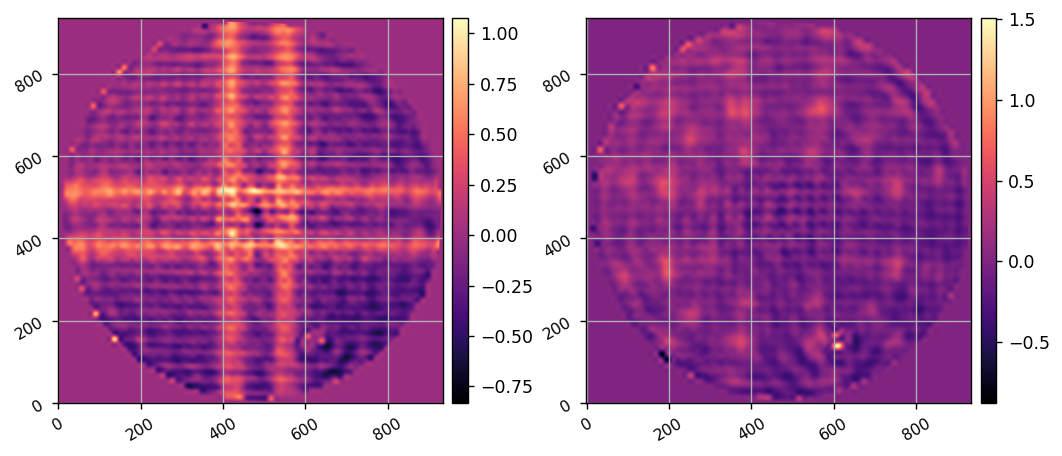

In [ ]:
reload(utils)
# npix = 1000
npix = 934
wavelength = 633e-9
shift = (0,5)
rotation = 2

i_amp_est = utils.interp_arr(xp.array(amp_est_ref), 1/Nfit, 1/npix, order=1)
i_amp_est = xcipy.ndimage.shift(i_amp_est, shift)
i_amp_est = utils.rotate_arr(i_amp_est, rotation, reshape=False, order=5)
imshow1(i_amp_est)

i_del_phs_ring_15 = utils.interp_arr(xp.array(del_phs_ring_15), 1/Nfit, 1/npix, order=5)
i_del_phs_ring_15 = xcipy.ndimage.shift(i_del_phs_ring_15, shift)
i_del_phs_ring_15 = utils.rotate_arr(i_del_phs_ring_15, rotation, reshape=False, order=5)

i_del_phs_ring_13 = utils.interp_arr(xp.array(del_phs_ring_13), 1/Nfit, 1/npix, order=5)
i_del_phs_ring_13 = xcipy.ndimage.shift(i_del_phs_ring_13, shift)
i_del_phs_ring_13 = utils.rotate_arr(i_del_phs_ring_13, rotation, reshape=False, order=5)

i_del_phs_cross = utils.interp_arr(xp.array(del_phs_cross), 1/Nfit, 1/npix, order=2)
i_del_phs_cross = xcipy.ndimage.shift(i_del_phs_cross, shift)
i_del_phs_cross = utils.rotate_arr(i_del_phs_cross, rotation, reshape=False, order=5)
print(i_del_phs_cross.shape)

i_del_phs_reg = utils.interp_arr(xp.array(del_phs_reg), 1/Nfit, 1/npix, order=5)
i_del_phs_reg = xcipy.ndimage.shift(i_del_phs_reg, shift)
i_del_phs_reg = utils.rotate_arr(i_del_phs_reg, rotation, reshape=False, order=5)

imshow2(i_del_phs_ring_15, i_del_phs_ring_13, grid=True)
imshow2(i_del_phs_cross, i_del_phs_reg, grid=True)

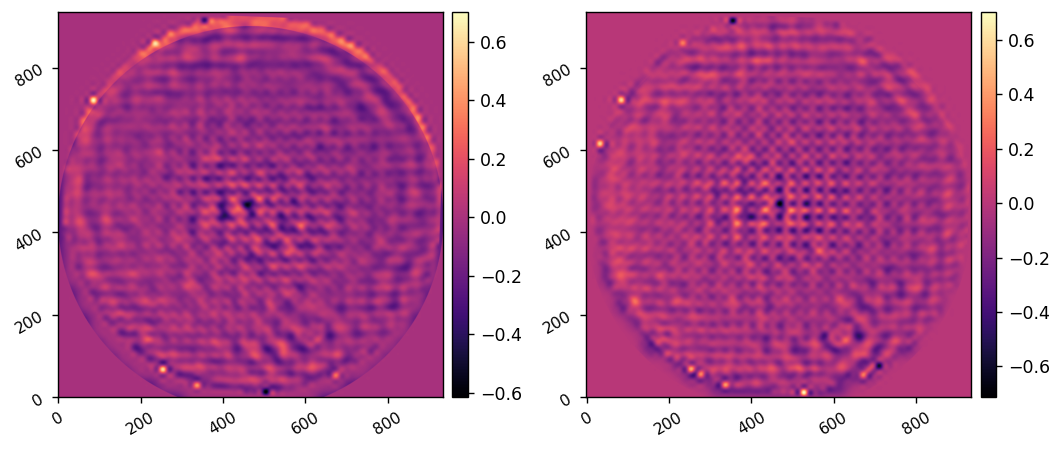

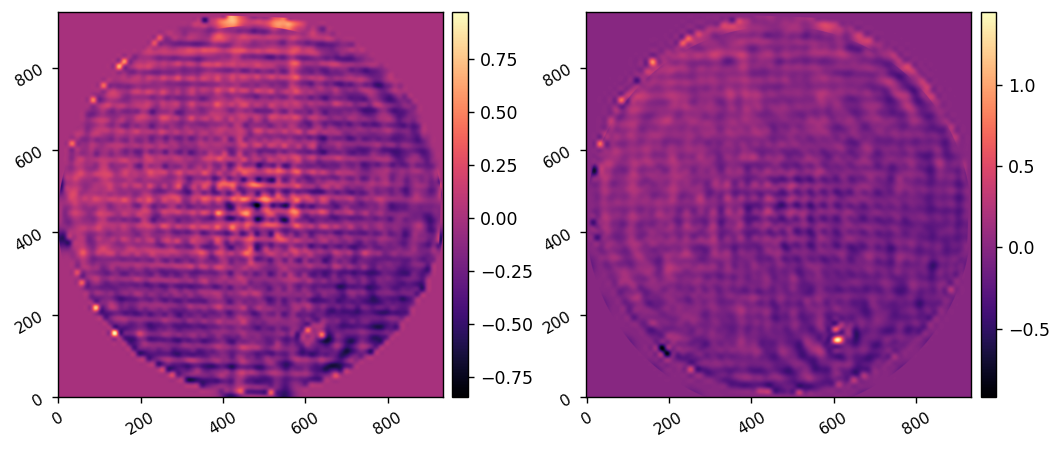

In [ ]:
dm_shift = (-35,0)

ring_15_diff = i_del_phs_ring_15 - utils.pad_or_crop(xcipy.ndimage.shift(m_dm_phs_ring_15, dm_shift), npix)/1.9
ring_13_diff = i_del_phs_ring_13 - utils.pad_or_crop(xcipy.ndimage.shift(m_dm_phs_ring_13, dm_shift), npix)/1.9
cross_diff = i_del_phs_cross - utils.pad_or_crop(xcipy.ndimage.shift(m_dm_phs_cross, dm_shift), npix)/1.9
reg_diff = i_del_phs_reg - utils.pad_or_crop(xcipy.ndimage.shift(m_dm_phs_reg, dm_shift), npix)/1.9
imshow2(ring_15_diff, ring_13_diff)
imshow2(cross_diff, reg_diff)

# Process the reference data and plug into the model.

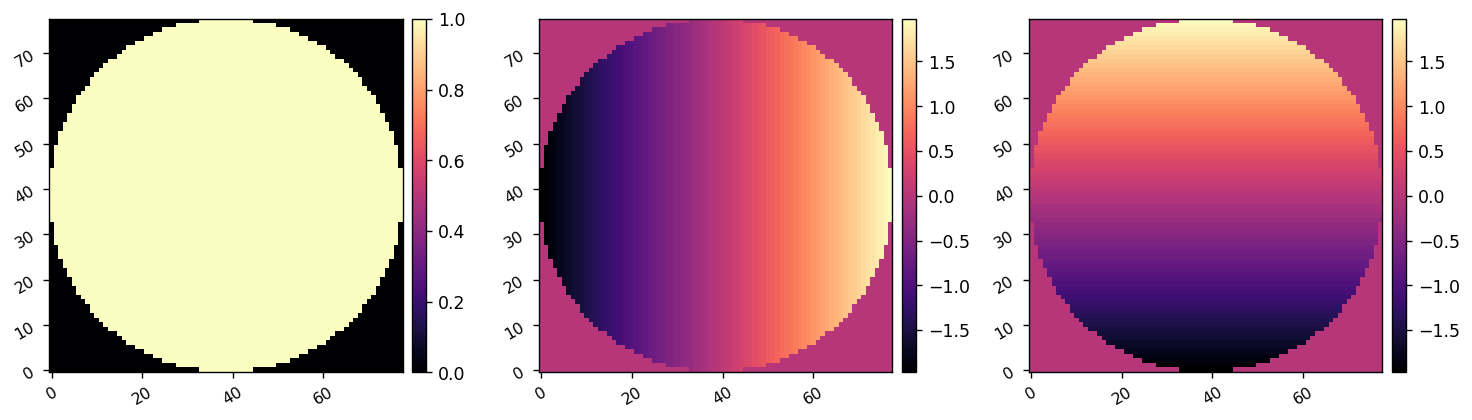

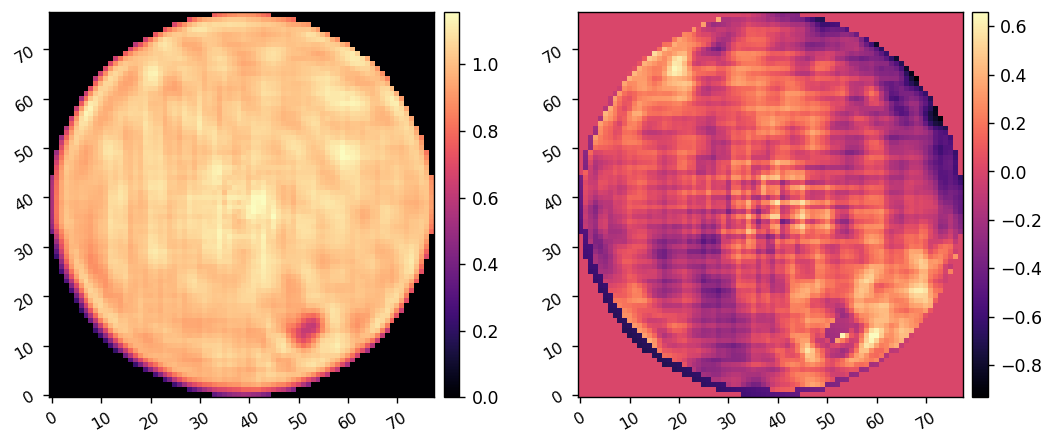

In [26]:
reload(utils)
ptt_modes = utils.create_zernike_modes(fit_mask, nmodes=3)
imshow3(ptt_modes[0], ptt_modes[1], ptt_modes[2])

ptt_coeff = utils.lstsq(ptt_modes, xp.array(phs_est_ref))
ptt = ensure_np_array( xp.sum(ptt_coeff[:, None, None] * ptt_modes, axis=0) ) 
phs_est_minus_ptt = phs_est_ref - ptt

amp_est_ref /= np.mean(amp_est_ref[fit_mask])

imshow2(amp_est_ref/np.mean(amp_est_ref[fit_mask]), phs_est_minus_ptt)

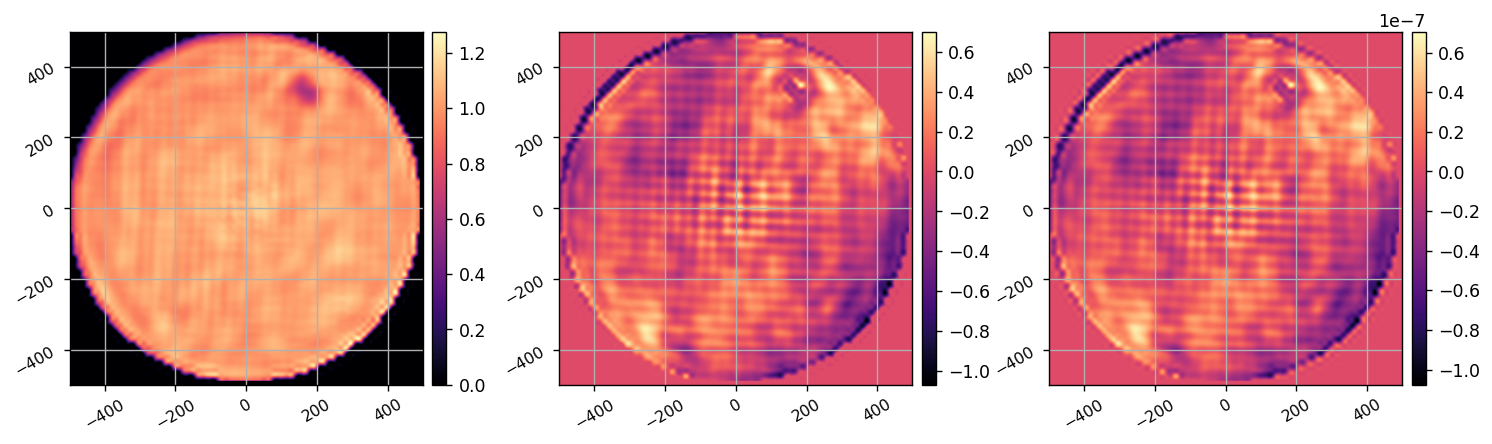

In [28]:
npix = 1000
shift = (0,0)
rotation = 0

iamp_est = utils.interp_arr(xp.array(amp_est_ref), 1/Nfit, 1/npix, order=5)
iphs_est = utils.interp_arr(xp.array(phs_est_minus_ptt), 1/Nfit, 1/npix, order=5)

iamp_est = xcipy.ndimage.shift(iamp_est, shift)
iphs_est = xcipy.ndimage.shift(iphs_est, shift)

iamp_est = utils.rotate_arr(iamp_est, rotation, reshape=False, order=5)
iphs_est = utils.rotate_arr(iphs_est, rotation, reshape=False, order=5)

iamp_est = xp.flipud(iamp_est)
iphs_est = xp.flipud(iphs_est)

iopd_est = iphs_est * wavelength / (2*np.pi)
iamp_est[iamp_est<0] = 0
processed_wfe = iamp_est * xp.exp(1j*iphs_est)

imshow3(xp.abs(processed_wfe), xp.angle(processed_wfe), iopd_est, pxscl=1, grid=True)


In [29]:
utils.save_pickle('data/processed_pr_amp.pkl', iamp_est)
utils.save_pickle('data/processed_pr_opd.pkl', iopd_est)

Saved data to:  data/processed_pr_amp.pkl
Saved data to:  data/processed_pr_opd.pkl


Oversampling > 2x suggested for reliable results in Fresnel propagation.


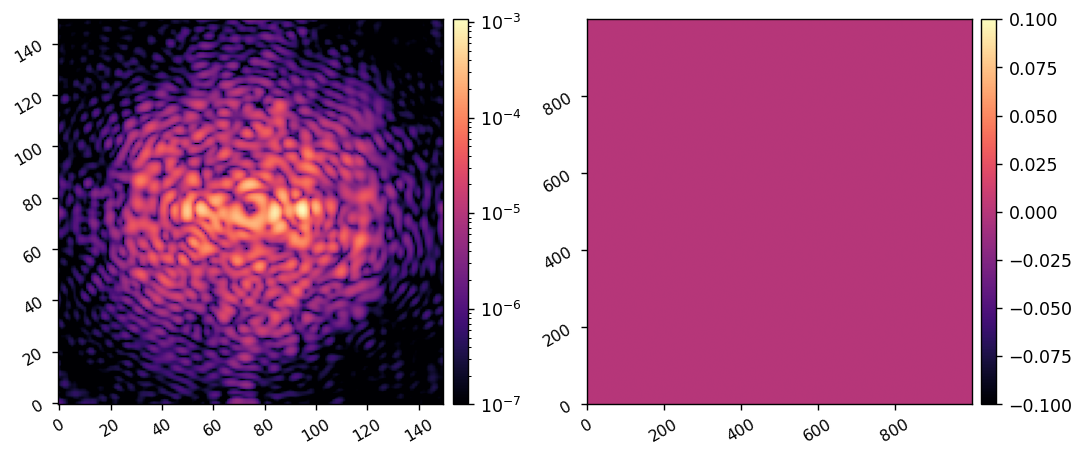

In [38]:
reload(scoobm)
M = scoobm.MODEL()
M.AMP = xp.array(utils.load_pickle('data/processed_pr_amp.pkl'))
M.OPD = xp.array(utils.load_pickle('data/processed_pr_opd.pkl'))

M.flip_dm = 1
M.flip_lyot_ud = 1

acts = xp.zeros(M.Nacts)
fpwf = M.forward(acts, M.wavelength_c, use_vortex=0, return_ints=0)
model_psf = xp.abs(fpwf)**2
M.Imax_ref = xp.max(model_psf)

acts = xp.zeros(M.Nacts)
fpwf, E_pup, dm_phasor = M.forward(acts, M.wavelength_c, use_vortex=True, return_ints=True)
img = xp.abs(fpwf)**2
dm_opd = xp.angle(utils.pad_or_crop(dm_phasor, M.npix)) * M.wavelength_c/(4*xp.pi)
imshow2(img, dm_opd, lognorm1=True, vmin1=1e-7)